In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import time



In [2]:
dfB = pd.read_csv("Datasets/s4.csv",header = 0, sep=";")
XB = dfB.to_numpy()
XB

"""dfB = pd.read_csv("fig2_panelB.csv",header = 0, sep=";")
XB = dfB.to_numpy()
XB
"""

'dfB = pd.read_csv("fig2_panelB.csv",header = 0, sep=";")\nXB = dfB.to_numpy()\nXB\n'

In [3]:
dfC = pd.read_csv("Datasets/fig2_panelC.csv",header = 0, sep=";")
XC = dfC.to_numpy()
XC

array([[-0.34576586,  0.7010113 ],
       [-0.34817964,  0.69643325],
       [-0.3435882 ,  0.69923502],
       ...,
       [-0.59184092,  1.26134372],
       [-0.07819092,  0.3031134 ],
       [-0.76162732,  0.38400239]])

<AxesSubplot:title={'center':'Scatter plot of the dataset'}, xlabel='X', ylabel='Y'>

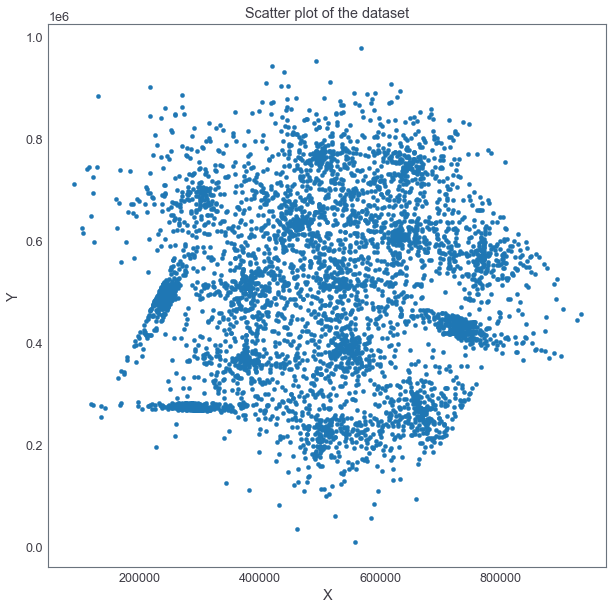

In [4]:
dfB.plot.scatter(x='X',y='Y',c='tab:blue',figsize=(10,10), title='Scatter plot of the dataset')


# Functions

In [5]:

def distance(array, metric ="euclidean"):
    return sklearn.metrics.pairwise_distances(array,metric=metric)
    
def local_density(cutoff, distances): # euclidian distance
    local_density = np.zeros(len(distances))
    for i in range(len(distances)) :
        # calculate the number of points which are closer than cutoff
        local_density[i] = (distances[i] < cutoff).sum()-1 # euclidian distance // -1 to remove self distance
    return local_density

def auto_cutoff(distances) :
    max_cutoff = np.max(distances)
    min_cutoff = np.min(distances)
    cutoff = (max_cutoff+min_cutoff)/2
    while True :
        target =  (distances <= cutoff).sum() / len(distances) ** 2
        if target > 0.01 and target < 0.02 :
            break
        if target < 0.01:
            min_cutoff = cutoff
        else:
            max_cutoff = cutoff
        cutoff = (max_cutoff + min_cutoff) / 2
        if max_cutoff - min_cutoff < 0.0001: 
            break 
    return cutoff

def delta_distance(rho, distances):
    desc_rho_idx = np.argsort(-rho)
    delta,neighbors = [0.0] + [float(np.max(distances))] * (len(distances)-1), [desc_rho_idx[0]] * len(distances)
    desc_distances = distances[desc_rho_idx]
    delta[desc_rho_idx[0]] = -1.
    for i in range(1,len(desc_distances)) : # find the min of pairwise distance for the i-th point from distance array
        filtered_row = desc_distances[i][desc_rho_idx[:i+1]]
        mask_nonzero = np.ma.masked_equal(filtered_row, 0.0, copy=False) # remove distance of 0.0
        delta[desc_rho_idx[i]] = mask_nonzero.min() # find min
        neighbors[desc_rho_idx[i]] = np.where(desc_distances[i] == mask_nonzero.min())[0][0] # find 
        # first index for neighbor
    delta[desc_rho_idx[0]] = max(delta)
    return delta, neighbors
    
def clustering(rho,delta,neighbors, distance_threshold, density_threshold, cutoff) :
    """ Prepare the clusters list and define the centers list"""
    clusters, centers = {}, {} 
    for idx, (density, distance, neighbor) in enumerate(zip(rho, delta, neighbors)):
        if distance * density >= distance_threshold*density_threshold :
            centers[idx] = idx
            clusters[idx] = idx
        else:
            clusters[idx] = -1     
            
    """ Assign each non-center point the cluster of the nearest neighbor """
    desc_rho_idx = np.argsort(-rho)
    for i in range(len(desc_rho_idx)) :
        if clusters[desc_rho_idx[i]] == -1:
            clusters[desc_rho_idx[i]] = clusters[neighbors[desc_rho_idx[i]]]

    """ Prepare the halo """
    border_rho = {k: 0.0 for k in centers.keys()}
    for i in range(len(rho)-1):
        for j in range(i+1,len(rho)):
            if clusters[i] != clusters[j] and distances[i][j] <= cutoff :
                if rho[i] > border_rho[clusters[i]]:
                    border_rho[clusters[i]] = rho[i]
                if rho[j] > border_rho[clusters[j]]:
                    border_rho[clusters[j]] = rho[j]
    for i in range(len(distances)):
        if rho[i] < border_rho[clusters[i]]:
            clusters[i] = -1000 # noise
    return clusters, centers



# Processing

In [6]:
""" Compute N x N distances matrix"""
#distances = distance(XB, "l2")
#distances = distance(XB, "manhattan")
start = time.time()
distances = distance(XB)

""" Compute 1 x N local density matrix"""
print("auto_cutoff value is : ",auto_cutoff(distances)*0.33)
rho = local_density(auto_cutoff(distances), distances)
#rho = local_density(0.051, distances)

""" Compute 1 x N delta matrix"""
delta, neighbors = delta_distance(rho, distances)

""" Compute gamma """
gamma = [a * b for a, b in zip(rho, delta)]

clusters, centers = clustering(rho,delta,neighbors, 50, 70000, auto_cutoff(distances)*0.33)
end = time.time()
print('computation time is :')
print(end - start, "sec")
#{1: 1, 293: 293, 324: 324, 376: 376, 482: 482}

auto_cutoff value is :  10046.473067857512
computation time is :
6.075824499130249 sec


# Decision graph

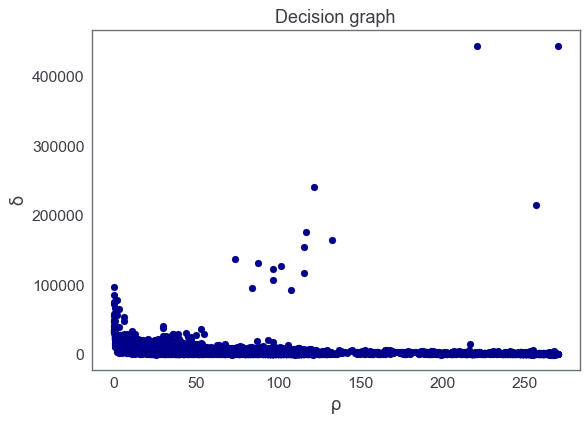

In [7]:
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter(rho,delta, c='Darkblue')
plt.xlabel("ρ")
plt.ylabel("ẟ")
plt.title("Decision graph")
plt.show()

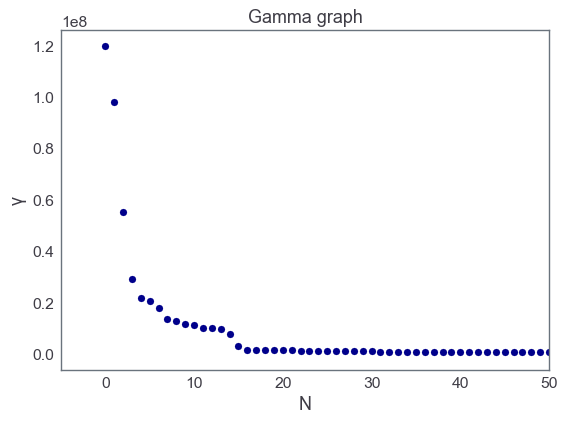

In [8]:
gamma.sort(reverse = True)
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter([i for i in range(len(gamma))], gamma, c='Darkblue')
plt.xlabel("N")
plt.xlim(-5,50)
plt.ylabel("γ")
plt.title("Gamma graph")
plt.show()

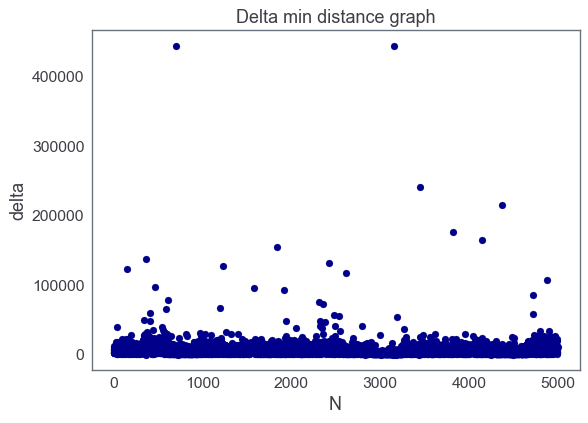

In [9]:
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter([i for i in range(len(delta))], delta, c='Darkblue')
plt.xlabel("N")
#plt.xlim(-5,100)
plt.ylabel("delta")
plt.title("Delta min distance graph")
plt.show()

{-1000: 1000, 155: 2000, 4884: 3000, 3826: 4000, 3453: 5000, 367: 6000, 4371: 7000, 2614: 8000, 1584: 9000, 706: 10000, 1235: 11000, 4144: 12000, 1834: 13000, 2420: 14000, 1915: 15000, 3154: 16000}


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


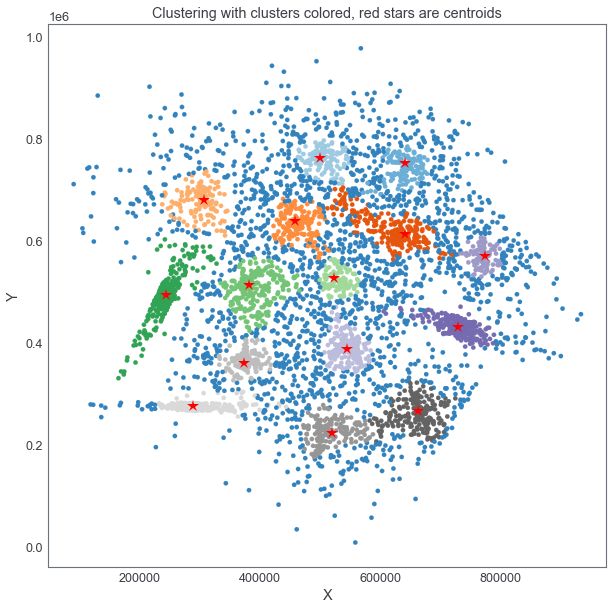

In [10]:
# prepare a dictionnary to assign each cluster a color
new_colors = {}
index = 1000
for element in clusters.values():
    if element in new_colors:
        continue
    else :
        new_colors[element] = index
        index+=1000


print(new_colors)
# plot the final scatter plot, each color represent one cluster
dfB.plot.scatter(x='X',y='Y',
                 color=[new_colors[clusters[i]] for i in clusters],
                 cmap='tab20c',
                 figsize=(10,10),
                 title = 'Clustering with clusters colored, red stars are centroids',
                 #c  = 'g',
                )

# plot the centroid with a red star
X = dfB['X']
Y = dfB['Y']
for idx in enumerate(centers):
    plt.plot(X[idx[1]], Y[idx[1]], 'red', marker = '*', markersize=12)
    if idx[1] == -1000:
        plt.plot(X[idx[0]], Y[idx[0]], color = 'black')
    #plt.text(X[idx[1]], Y[idx[1]], idx)



In [11]:
d = pd.Series(delta)
d.describe()

count      5000.000000
mean       6706.775730
std       13031.726917
min          17.204651
25%        2365.454441
50%        4696.454088
75%        8154.683844
max      444544.174000
dtype: float64

In [12]:
print(list(clusters.values()))

[-1000, 155, -1000, 4884, 155, 155, 155, 4884, -1000, -1000, 155, -1000, -1000, -1000, 155, 155, 3826, -1000, -1000, -1000, -1000, -1000, -1000, 155, 155, 155, 155, -1000, -1000, -1000, -1000, 155, -1000, -1000, -1000, -1000, 155, -1000, -1000, 155, -1000, 155, 155, 155, -1000, 155, -1000, 155, 155, -1000, -1000, 3453, 3826, 155, 155, -1000, -1000, 155, -1000, 155, 155, 155, 155, -1000, 155, -1000, -1000, -1000, -1000, -1000, 155, -1000, -1000, 155, -1000, -1000, 155, -1000, 155, -1000, 155, -1000, 3826, 155, 155, -1000, -1000, -1000, 155, -1000, -1000, 155, 155, -1000, -1000, 155, -1000, -1000, -1000, -1000, -1000, -1000, 155, 155, -1000, 155, -1000, 155, 155, 155, -1000, -1000, -1000, 155, 155, -1000, -1000, -1000, 155, 155, 4884, 155, -1000, 155, -1000, 155, 155, 155, 155, 155, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 4884, -1000, -1000, 155, -1000, 155, -1000, -1000, -1000, 155, -1000, -1000, -1000, 155, -1000, -1000, -1000, 155, -1000, -1000, -1000, 155, -1000, 155,

In [13]:
print(centers)
print(len(centers), "centers")

{155: 155, 367: 367, 706: 706, 1235: 1235, 1584: 1584, 1834: 1834, 1915: 1915, 2420: 2420, 2614: 2614, 3154: 3154, 3453: 3453, 3826: 3826, 4144: 4144, 4371: 4371, 4884: 4884}
15 centers


computation time is :
0.11942720413208008 sec
[-1  0 -1 ... -1 -1 -1]


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'DBSCAN clustering'}, xlabel='X', ylabel='Y'>

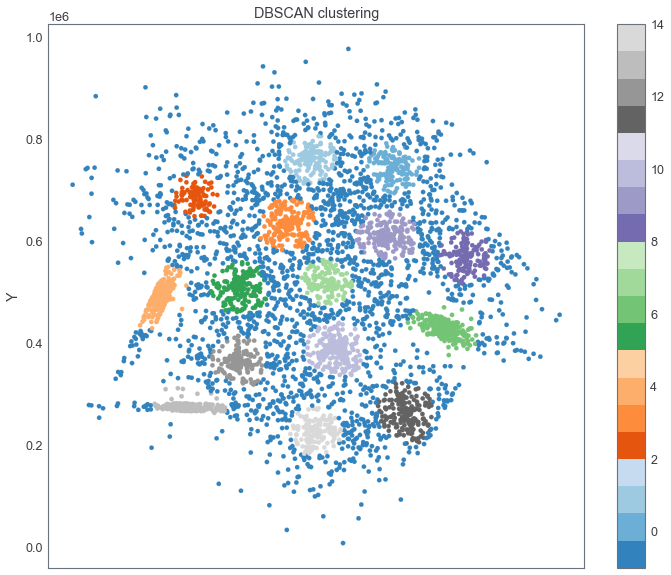

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
start = time.time()
X = StandardScaler().fit_transform(XB)
clustering = DBSCAN(eps=0.15, min_samples=50).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
print(clustering.labels_)

dfB.plot.scatter(x='X',y='Y',
                 color=clustering.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'DBSCAN clustering',
                 #c  = 'g',
                )

computation time is :
58.16056537628174 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Mean shift clustering'}, xlabel='X', ylabel='Y'>

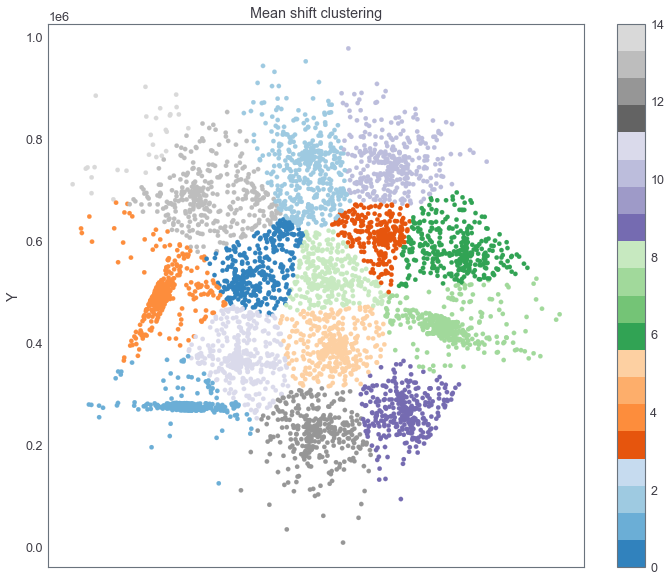

In [15]:
from sklearn.cluster import MeanShift
start = time.time()
X = StandardScaler().fit_transform(XB)
clustering = MeanShift(bandwidth = 0.5).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=clustering.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'Mean shift clustering',
                 #c  = 'g',
                )

computation time is :
0.6065008640289307 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'KMeans clustering with k = 15'}, xlabel='X', ylabel='Y'>

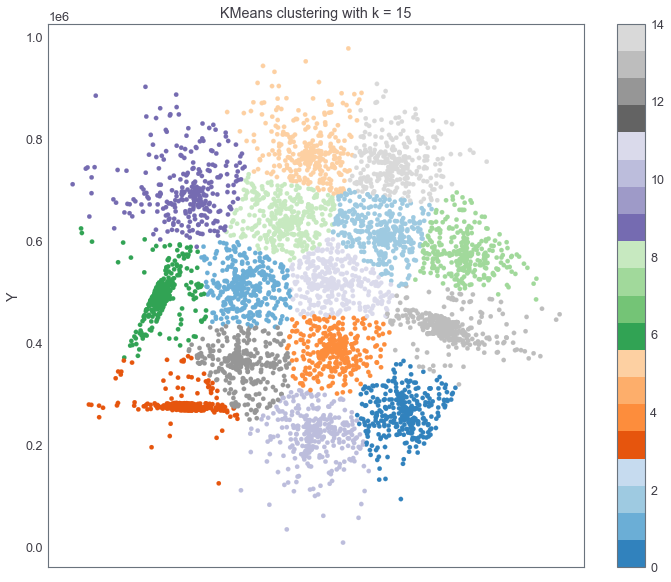

In [16]:
from sklearn.cluster import KMeans

start = time.time()
X = StandardScaler().fit_transform(XB)
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=kmeans.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'KMeans clustering with k = 15',
                 #c  = 'g',
                )

computation time is :
0.4074432849884033 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Gaussian mixture clustering with n = 15'}, xlabel='X', ylabel='Y'>

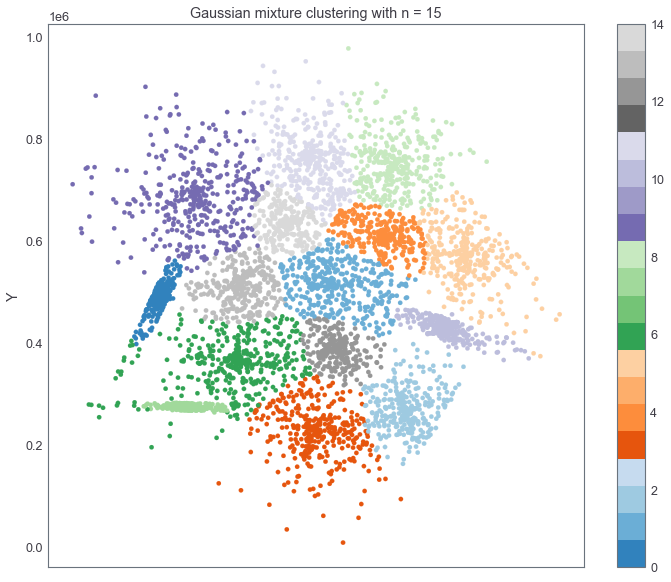

In [17]:
from sklearn.mixture import GaussianMixture

start = time.time()
X = StandardScaler().fit_transform(XB)
gm = GaussianMixture(n_components=15, random_state=0).fit_predict(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=gm,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'Gaussian mixture clustering with n = 15',
                 #c  = 'g',
                )